## Problem 1
Implement a random graph generator in the freshness model. Explore the degree distribution, the proportion of edges connecting vertices with age difference greater than T and the properties of the local clustering coefficient

In [45]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
import numpy as np
from collections import defaultdict
from collections import Counter

In [46]:
# quality generation
def random_qual():
    #return random.random()
    return np.random.power(2.5)

In [47]:
def first_br(qual):
    return qual
    #return [1 for i in qual]

In [48]:
def second_br(degree):
    #return degree
    return [1 for _ in degree]

In [73]:
def third_br(t,n,alpha):
    N = N_func(n,alpha)
#     return [1 if (i>t-N) else 0 for i in range(t+1)]
    return [math.exp(-(t-i)/N) for i in range(t+1)]
#     return [1 for i in range(t+1)]

In [67]:
def N_func(n, alpha):
    return round(n/alpha)

In [51]:
# attractivity function
def calc_nodes_attr(G,qual,t,n,alpha):
    degrees = nx.degree(G)
    
    first = first_br(qual)
    second = second_br([i for _,i in degrees])
    third = third_br(t,n, alpha)
    
    attr = [first[i]*second[i]*third[i] for i in range(t+1)]
    return attr

In [52]:
def generate_freshness_graph(n,m,alpha):
    G = nx.MultiDiGraph()
    G.add_edge(1,0)
    
    quals = [random_qual() for i in range(2)]
    for t in range(2,n):
        G.add_node(t)
        qual_new = random_qual()
        quals.append(qual_new)
        attr_new = calc_nodes_attr(G,quals,t,n,alpha)
        for edge in range(m):
            new_dest = random.choices(list(G.nodes()),attr_new, k = 1)[0]
            G.add_edge(t,new_dest)
    return(G)

In [74]:
n = 1000
m = 3
alpha = 2
G = generate_freshness_graph(n,m,alpha)

In [75]:
age_diff = defaultdict(int)
for i,j in G.edges():
    diff = abs(i - j)
    age_diff[diff] += 1/G.number_of_edges()

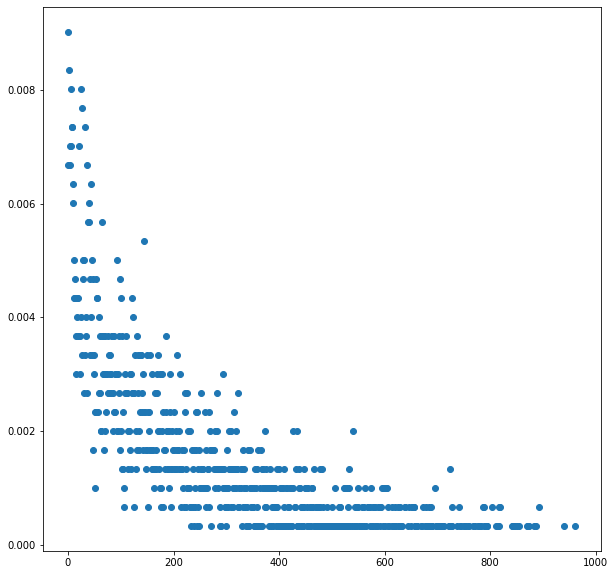

In [76]:
plt.plot(age_diff.keys(),age_diff.values(), ls='None',marker='o')
# plt.yscale('log')

In [77]:
sorted_ages = sorted(age_diff.items(), key = lambda x: x[0])

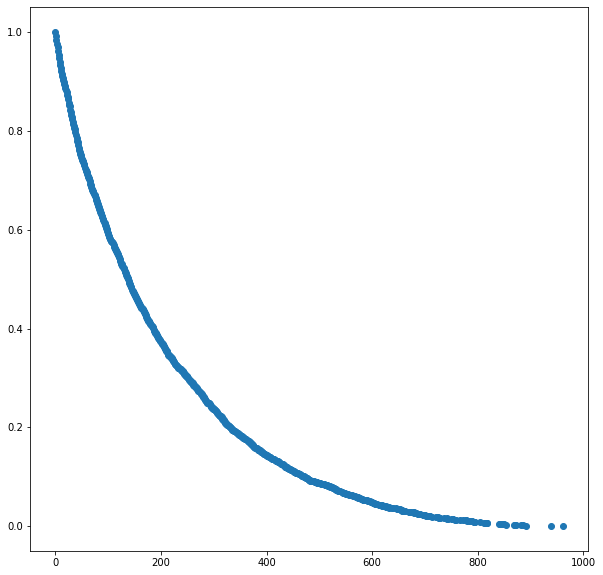

In [78]:
plt.plot([x[0] for x in sorted_ages],[sum([x[1] for x in sorted_ages[i:]]) for i in range(len(sorted_ages))], ls='None',marker='o')

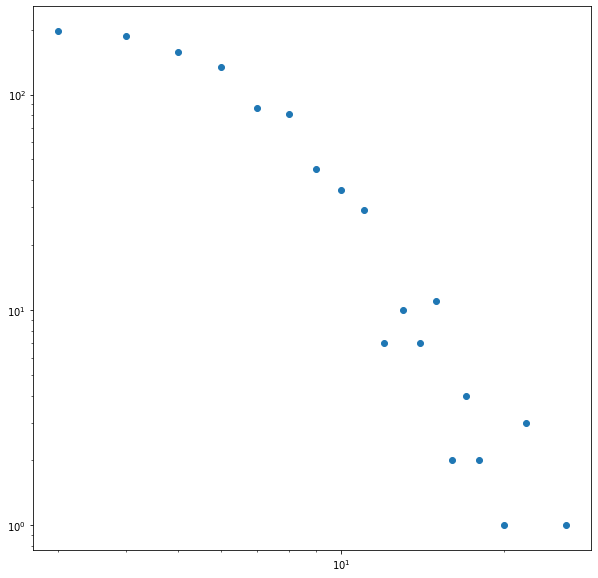

In [79]:
degrees = nx.degree(G)
degrees_dict = Counter([deg for _,deg in degrees])
plt.loglog(degrees_dict.keys(),degrees_dict.values(),ls='None',marker='o') 

In [80]:
G_simple = nx.Graph(G) 

In [81]:
clust_coeffs = nx.clustering(G_simple)
degrees = nx.degree(G_simple)

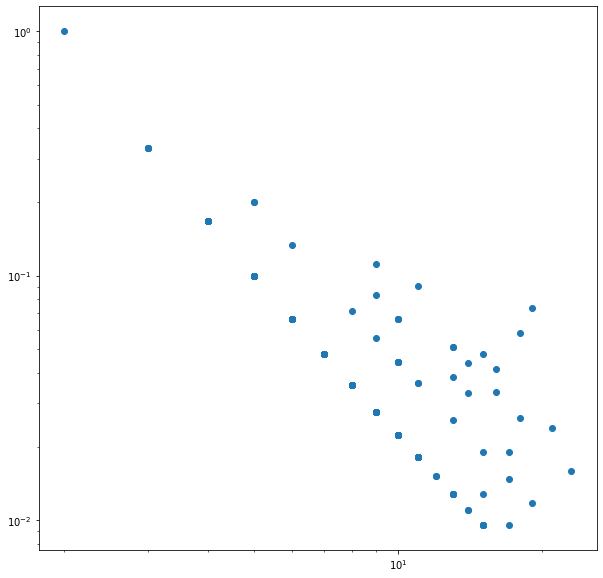

In [82]:
plt.loglog([value for _, value in degrees],clust_coeffs.values(),ls='None',marker='o')

In [84]:
unique_degrees = np.unique([value for _, value in degrees])
clust_dict = {}
for deg in unique_degrees:
    nodes =[key for key, _ in filter(lambda x: x[1]==deg, degrees)]
    clust_tmp = [clust_coeffs[key] for key in nodes]
    clust_dict[deg] = np.mean(clust_tmp)

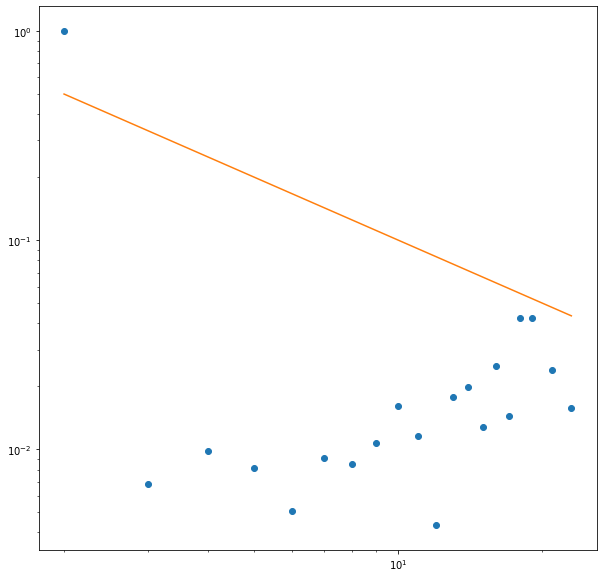

In [85]:
plt.loglog(unique_degrees,clust_dict.values(),ls='None',marker='o')
plt.loglog(unique_degrees, [1/x for x in unique_degrees])

In [86]:
clust_coeffs = {}
n_list = list(range(100,2000,100))
n_list.append(5000)
for n in n_list:
    print(n)
    G = generate_freshness_graph(n,3,2)
    G_simple = nx.Graph(G) 
    clust_coeff = np.mean([x for _,x in nx.clustering(G_simple).items()])
    clust_coeffs[n] = clust_coeff

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
5000


(0.0015039278227642744, 0.10805887445887445)

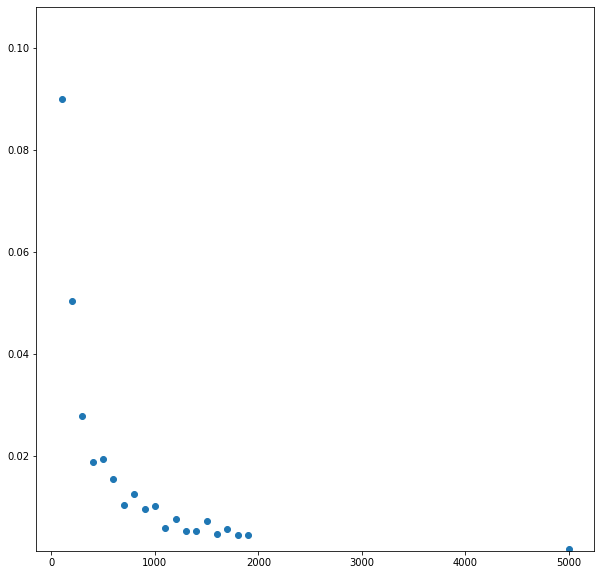

In [87]:
plt.plot(clust_coeffs.keys(),clust_coeffs.values(),ls='None',marker='o')
plt.ylim(top=max(clust_coeffs.values())*1.2, bottom = min(clust_coeffs.values())*0.8)

## Problem 2
Suppose that G(n,m) is obtained in the freshness model with the attractivity function $attr_t(i)=q(i)*e^{-(t-i)/N(n)}$, where N(n) = round(n/$\alpha$) and $q(i)\ \forall i$ are fixed known numbers. Find the parameter $\alpha$ value using the Likelihood Maximization approach. n = 1000, m =3

In [88]:
def generate_freshness_graph_fixed_qual(n,m,quals,alpha):
    G = nx.MultiDiGraph()
    G.add_edge(1,0)
    
    for t in range(2,n):
        G.add_node(t)
        attr_new = calc_nodes_attr(G,quals[:(t+1)],t,n,alpha)
        for edge in range(m):
            new_dest = random.choices(list(G.nodes()),attr_new, k = 1)[0]
            G.add_edge(t,new_dest)
    return(G)

In [93]:
n= 1000
m = 3
alpha = 4
quals = [random_qual() for i in range(n)]
G = generate_freshness_graph_fixed_qual(1000,3,quals,alpha)

In [90]:
def likelihood(n,G,quals,alpha):
    edges = list(G.edges())
    probs_dict = {}
    for t in range(1,n):
        attr = calc_nodes_attr(G,quals[:(t+1)],t,n,alpha)
        sum_attr = sum(attr)
        probs =[i/sum_attr for i in attr]
        probs_dict[t] = probs   
    
    lkh = 0
    for t,i in edges:
        lkh += math.log(probs_dict[t][i])
    return lkh

In [94]:
lkh_values = []
for alpha_tmp in range(3,8):
    print(alpha_tmp)
    lkh_values.append(likelihood(n,G,quals,alpha_tmp))

3
4
5
6
7


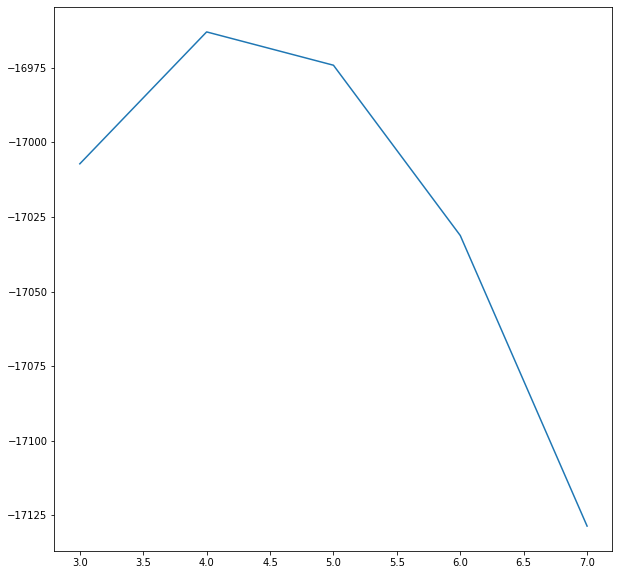

In [95]:
plt.plot(range(3,8),lkh_values)

## Problem 3
Generate graph in the copy model with $n=10\,000$ nodes and $d=1$, $\alpha=1/4.$ In $\log$-coordinates plot the in-degree distribution in the simulated graph and its theoretical estimate.
Plot the in-degree distribution also for $d=5$.

In [96]:
import networkx as nx
import random

def generate_copying_model_graph(n, d, alpha, G0):
    G = G0.copy()
    while G.number_of_nodes() < n:
        # the node to copy links 
        p = random.choice(list(G.nodes()))
        # ends of the new edges:
        destinations = []
        for i in range(d):
            if random.random() < alpha:
                # edge end is any random node in the graph
                destination = random.choice(list(G.nodes()))
            else:
                # copy ith neighbour of p:
                destination = list(G.out_edges(p))[i][1]
            destinations.append(destination)
        new_node = G.number_of_nodes()
        for dest in destinations:
            G.add_edge(new_node, destination)
    return G   

In [97]:
G0 = nx.MultiDiGraph()
G0.add_edge(0, 0)
alpha = 0.25
G = generate_copying_model_graph(10000, 1, alpha, G0)

In [100]:
import matplotlib.pyplot as plt
import pylab
from collections import Counter

degrees = Counter(dict(G.in_degree()).values())
sorted_degree_values = sorted(dict(G.in_degree()).keys())
counts = [degrees[d] for d in sorted_degree_values]


In [101]:
from scipy.optimize import curve_fit
import numpy as np
def func(d, c):
    return float(c) / ( d ** ((2 - alpha)/(1 - alpha)) )

xdata = np.array(sorted_degree_values[3:20])
ydata = np.array(counts[3:20])
popt, pcov = curve_fit(func, xdata, ydata)
print(popt)

[2333.35140571]


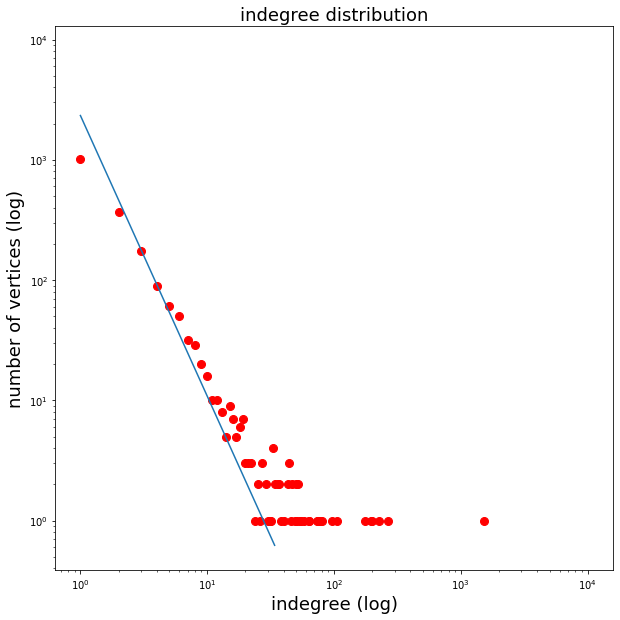

In [102]:
pylab.rcParams['figure.figsize'] = 10, 10
plt.loglog(sorted_degree_values, counts, ls='None', marker='o', color='r', markersize=8)
plt.loglog(sorted_degree_values[1:35], [ popt[0]/ r ** ( (2 - alpha) / (1 - alpha)) for r in sorted_degree_values[1:35]])
plt.xlabel("indegree (log)", fontsize=18)
plt.ylabel("number of vertices (log)", fontsize=18)
plt.title("indegree distribution", fontsize=18)
plt.show()

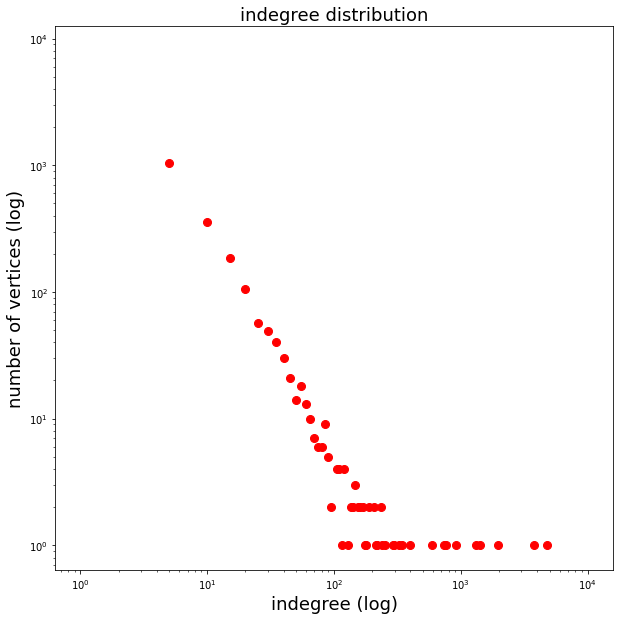

In [103]:
G0 = nx.MultiDiGraph()
G0.add_edge(0, 0)
G0.add_edge(0, 0)
G0.add_edge(0, 0)
G0.add_edge(0, 0)
G0.add_edge(0, 0)
G = generate_copying_model_graph(10000, 5, alpha, G0)
degrees = Counter(dict(G.in_degree()).values())
sorted_degree_values = sorted(dict(G.in_degree()).keys())
counts = [degrees[d] for d in sorted_degree_values]


pylab.rcParams['figure.figsize'] = 10, 10
plt.loglog(sorted_degree_values, counts, ls='None', marker='o', color='r', markersize=8)
plt.xlabel("indegree (log)", fontsize=18)
plt.ylabel("number of vertices (log)", fontsize=18)
plt.title("indegree distribution", fontsize=18)
plt.show()

## Problem 4
Generate graph in Holme-Kim model using networkx function powerlaw_cluster_graph.
Analyse properties of the local clustering coefficient.

In [104]:
n = 10000
m = 5
p = 0.1
G =  nx.powerlaw_cluster_graph(n, m, p)

In [105]:
cl = nx.average_clustering(G)

In [106]:
cl

0.03961350161758061

In [107]:
n_list = [100, 200, 500, 1000, 5000, 10000, 20000]
p_list = [x/10 for x in range(1,6)]
clust_dict = {}
trans_dict = {}
for p in p_list:
    clust_dict[p] = []
    trans_dict[p] = []
    for n in n_list:
        print(f'TF prob ={p}, n ={n}')
        G =  nx.powerlaw_cluster_graph(n, m, p)
        cl = nx.average_clustering(G)
        tr = nx.transitivity(G)
        clust_dict[p].append(cl)
        trans_dict[p].append(tr)

TF prob =0.1, n =100
TF prob =0.1, n =200
TF prob =0.1, n =500
TF prob =0.1, n =1000
TF prob =0.1, n =5000
TF prob =0.1, n =10000
TF prob =0.1, n =20000
TF prob =0.2, n =100
TF prob =0.2, n =200
TF prob =0.2, n =500
TF prob =0.2, n =1000
TF prob =0.2, n =5000
TF prob =0.2, n =10000
TF prob =0.2, n =20000
TF prob =0.3, n =100
TF prob =0.3, n =200
TF prob =0.3, n =500
TF prob =0.3, n =1000
TF prob =0.3, n =5000
TF prob =0.3, n =10000
TF prob =0.3, n =20000
TF prob =0.4, n =100
TF prob =0.4, n =200
TF prob =0.4, n =500
TF prob =0.4, n =1000
TF prob =0.4, n =5000
TF prob =0.4, n =10000
TF prob =0.4, n =20000
TF prob =0.5, n =100
TF prob =0.5, n =200
TF prob =0.5, n =500
TF prob =0.5, n =1000
TF prob =0.5, n =5000
TF prob =0.5, n =10000
TF prob =0.5, n =20000


Text(0.5, 1.0, 'Mean local clustering coefficient')

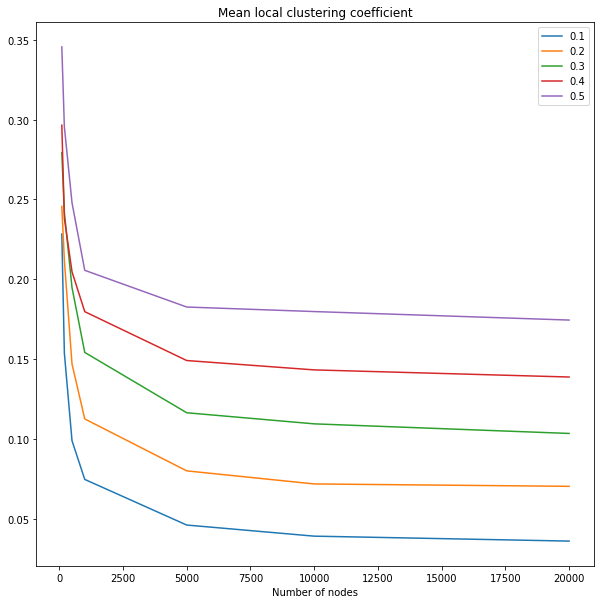

In [108]:
plt.figure()

for p in p_list:
    plt.plot(n_list, clust_dict[p], label = p)
plt.legend()
plt.xlabel('Number of nodes')
plt.title('Mean local clustering coefficient')

Text(0.5, 1.0, 'Transitivity')

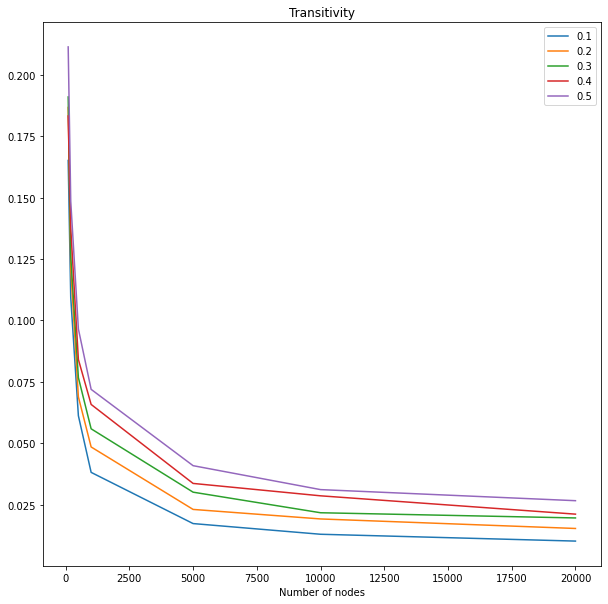

In [109]:
plt.figure()

for p in p_list:
    plt.plot(n_list, trans_dict[p], label = p)
plt.legend()
plt.xlabel('Number of nodes')
plt.title('Transitivity')